In [147]:
import numpy as np
import scipy
from scipy import integrate
from numpy.random import default_rng
from multiprocessing import Pool
import nfwFunctions as NFW
import inverseTransform
import time

from scipy import special
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

In [148]:
class halo():
    def __init__(self, rScale, rho0, delta, rhoCritical = 1.26*10**-7):
        self.rho0 = rho0
        self.rScale = rScale
        self.G = 4.3009*10**-3
        self.rhoCritical = rhoCritical
        self.delta = delta
        rhoNorm = rho0/(delta*rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        self.c = ( cShortcut + 1./cShortcut - 2 )/3.
        self.rDelta = self.c*self.rScale
        self.mHalo = (4*np.pi*self.rho0*self.rScale**3)*NFW.gFcn(self.c)
        self.virialSpeed = np.sqrt(self.G*self.mHalo/self.rDelta)
        self.energyNorm = 4*np.pi*self.rho0*self.G*self.rScale**2
        
    def relativeEnergy(self,r,s):
        return 4*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale)) - (1/2)*s**2
    
    def relativePotential(self,r):
        return 4*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale))
    
    #def PSD_Eddington(self,r,s):
    #    const = 4*np.pi*self.rho0*self.G*self.rScale**2
    #    prefactor = -self.rho0/(const**3*np.sqrt(8)*np.pi**2)
    #    eps = self.relativeEnergy(r,s)
    #    if eps<0:
    #        return 0
    #    else:
    #        integrand = lambda psi: prefactor*(psi/const)*(4*psi+3*(const+2*psi)*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))+6*const*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2)/(np.sqrt(np.abs(eps-psi))*np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1))**2*(1+np.real(special.lambertw((-psi/const)*np.exp(-psi/const),-1)))**3)
    #        return integrate.quad(integrand,0,eps)[0]
        
    def gFcn(self,x):
        return np.log(1+x)-(x/(1+x))
    
    def maxSpeed(self,r):
        return np.sqrt(8*np.pi*self.rho0*self.G*self.rScale**2*(np.log(1+(r/self.rScale))/(r/self.rScale) - np.log(1+(self.rDelta/self.rScale))/(self.rDelta/self.rScale)))
        
    def PSD_MB(self,r,s):
        eps = self.relativeEnergy(r,s)
        if eps<0:
            return 0
        else:
            disp = np.sqrt(self.virialSpeed**2*\
                        ((self.c**2*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)/self.gFcn(self.c))*\
                        integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*(r/self.rDelta), np.inf)[0]
                        )
            return (1/(self.c*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)) * np.exp(-s**2/(2*disp**2))/( np.sqrt(128*np.pi**5) * self.rScale**3 * disp**3 * self.gFcn(self.c))
        
    def PSD_MB_noCutoff(self,r,s):
        eps = self.relativeEnergy(r,s)
        disp = np.sqrt(self.virialSpeed**2*\
                    ((self.c**2*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)/self.gFcn(self.c))*\
                    integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*(r/self.rDelta), np.inf)[0]
                    )
        return (1/(self.c*(r/self.rDelta)*(1+self.c*(r/self.rDelta))**2)) * np.exp(-s**2/(2*disp**2))/( np.sqrt(128*np.pi**5) * self.rScale**3 * disp**3 * self.gFcn(self.c))
    
    #def PSD_Eddington_2(self,r,s):
    #    eps = self.relativeEnergy(r,s)
    #    if eps<0:
    #        return 0
    #    else:
    #        integrand = lambda psi: self.dNu_dPsi_second(psi)/np.sqrt(np.abs(psi-eps))
    #        return integrate.quad(integrand,0,eps)[0]
        
    #def PSD_Eddington_2_callByEnergy(self,eps):
    #    if eps<0:
    #        return 0
    #    else:
    #        integrand = lambda psi: self.dNu_dPsi_second(psi)/np.sqrt(np.abs(psi-eps))
    #        return integrate.quad(integrand,0,eps)[0]
        
    def PSD_Eddington_3(self,r,s):
        eps = self.relativeEnergy(r,s)
        if eps<0:
            return 0
        else:
            epsNorm = eps/self.energyNorm
            PhiNorm = -np.log(1+self.c)/self.c

            prefactor = 1./(np.sqrt(128)*np.pi**3*self.rScale**3*self.energyNorm**(3./2.)*self.gFcn(self.c))
            #print(prefactor)

            integrand = lambda PsiNorm: -(PsiNorm-PhiNorm)**3*(1+(self.A_Norm(PsiNorm)/(PsiNorm-PhiNorm)))*(2+(1+(self.A_Norm(PsiNorm)/(1+self.A_Norm(PsiNorm))))*((3*self.A_Norm(PsiNorm)/(PsiNorm-PhiNorm))+2))/(np.sqrt(np.abs(PsiNorm-epsNorm))*self.A_Norm(PsiNorm)**2*(1+self.A_Norm(PsiNorm))**2*(PsiNorm-PhiNorm+self.A_Norm(PsiNorm)))
            return prefactor*integrate.quad(integrand,0,epsNorm)[0]
    
    def A_Norm(self,PsiNorm):
        PhiNorm = -np.log(1+self.c)/self.c
        return np.real(special.lambertw(-(PsiNorm-PhiNorm)*np.exp(-(PsiNorm-PhiNorm)),-1))
            
    #def A(self,psi):
    #    b = 4*np.pi*self.rho0*self.G*self.rScale**2
    #    gamma = np.log(1+self.c)/self.c
    #    return np.real(special.lambertw(-(psi/b+gamma)*np.exp(-(psi/b+gamma)),-1))
            
    #def nu(self,psi):
    #    b = 4*np.pi*self.rho0*self.G*self.rScale**2
    #    gamma = np.log(1+self.c)/self.c
    #    return (-1/(4*np.pi*self.rScale**3*self.gFcn(self.c)))*(psi/b+gamma)**3/(self.A(psi)**2*((psi/b+gamma)+self.A(psi)))
    
    #def dNu_dPsi_first(self,psi):
    #    b = 4*np.pi*self.rho0*self.G*self.rScale**2
    #    gamma = np.log(1+self.c)/self.c
    #    return (self.nu(psi)/(b*(1+self.A(psi))))*((3*self.A(psi)/(psi/b+gamma))+2)
        
    #def dNu_dPsi_second(self,psi):
    #    b = 4*np.pi*self.rho0*self.G*self.rScale**2
    #    gamma = np.log(1+self.c)/self.c
    #    return (self.nu(psi)/(b*(1+self.A(psi)))**2)*(1+(self.A(psi))/(psi/b+gamma))*(2+(1+(self.A(psi)/(1+self.A(psi))))*((3*self.A(psi)/(psi/b+gamma))+2))
    
    #def mass_density(self,r):
    #    return self.rho0/((r/self.rScale)*(1+r/self.rScale)**2)
        
    #def nu_r_by_mass(self,r):
    #    mass = 4*np.pi*self.rho0*self.rScale**3*self.gFcn(self.c)
    #    return self.mass_density(r)/mass
    
    #def nu_r(self,r):
    #    psi = self.relativePotential(r)
    #    integrand = lambda eps: self.PSD_Eddington_2_callByEnergy(eps)*np.sqrt(2*(psi-eps))
    #    return 4*np.pi*integrate.quad(integrand,0,psi)[0]
    

In [149]:
rScale = 10*10**3
mwHaloDensity = 4.88664 * 10 ** -2 # This is the density that gives a mass of 10^12 for rScale = 10,000 kPc
delta = 200 # cutoff scale
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

# Create an instance of the nfwHalo class
mwHalo = halo(rScale,mwHaloDensity,delta,criticalDensity)

In [150]:
nRadii = 100
nSpeeds = 100

maxRadius = mwHalo.rDelta
testradii = np.linspace(0.001,maxRadius,100)
ms = np.zeros(100)
for k in range(100):
    ms[k] = mwHalo.maxSpeed(testradii[k])
maxSpeed = np.max(ms)

radii = np.linspace(1,maxRadius,nRadii) # in parsecs
speeds = np.linspace(0,maxSpeed,nSpeeds) # in km/s

In [152]:
pdfEddingtonImage = np.zeros((nRadii,nSpeeds))
pdfMBImage = np.zeros((nRadii,nSpeeds))
#pdfMBImageNoCutoff = np.zeros((nRadii,nSpeeds))

for i in range(nRadii):
    for j in range(nSpeeds):
        pdfEddingtonImage[i,j] = (4*np.pi*radii[i]*speeds[j])**2*mwHalo.PSD_Eddington_3(radii[i],speeds[j])
        pdfMBImage[i,j] = (4*np.pi*radii[i]*speeds[j])**2*mwHalo.PSD_MB(radii[i],speeds[j])
        #pdfMBImageNoCutoff[i,j] = (4*np.pi*radii[i]*speeds[j])**2*mwHalo.phaseSpaceDensityMB_noCutoff(radii[i],speeds[j])

<ipython-input-148-61d365902d02>:84: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return prefactor*integrate.quad(integrand,0,epsNorm)[0]
<ipython-input-148-61d365902d02>:83: RuntimeWarning: divide by zero encountered in double_scalars
  integrand = lambda PsiNorm: -(PsiNorm-PhiNorm)**3*(1+(self.A_Norm(PsiNorm)/(PsiNorm-PhiNorm)))*(2+(1+(self.A_Norm(PsiNorm)/(1+self.A_Norm(PsiNorm))))*((3*self.A_Norm(PsiNorm)/(PsiNorm-PhiNorm))+2))/(np.sqrt(np.abs(PsiNorm-epsNorm))*self.A_Norm(PsiNorm)**2*(1+self.A_Norm(PsiNorm))**2*(PsiNorm-PhiNorm+self.A_Norm(PsiNorm)))
<ipython-input-148-61d365902d02>:84: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return prefactor*integrate.quad(integrand,0,epsNorm)[0]


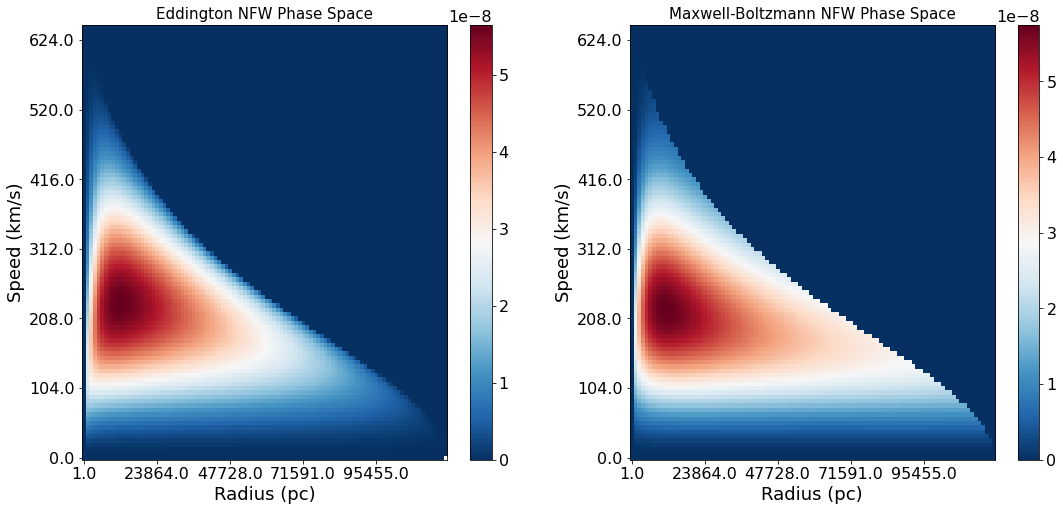

In [153]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8))
axis1 = ax1.imshow(np.transpose(pdfEddingtonImage),origin='lower',aspect='auto',cmap='RdBu_r')

num_x_labels = 6
step_r = int(nRadii/(num_x_labels-1))
ax1.set_xticks(np.arange(0,nRadii,step_r))
ax1.set_xticklabels(np.round(radii[::step_r]))
ax1.set_xlabel('Radius (pc)')

num_y_labels = 7
step_s = int(nSpeeds/(num_y_labels-1))
ax1.set_yticks(np.arange(0,nSpeeds,step_s))
ax1.set_yticklabels(np.round(speeds[::step_s]))
ax1.set_ylabel('Speed (km/s)')
ax1.set_title('Eddington NFW Phase Space')
fig.colorbar(axis1,ax=ax1)

axis2 = ax2.imshow(np.transpose(pdfMBImage),origin='lower',aspect='auto',cmap='RdBu_r')

num_x_labels = 6
step_r = int(nRadii/(num_x_labels-1))
ax2.set_xticks(np.arange(0,nRadii,step_r))
ax2.set_xticklabels(np.round(radii[::step_r]))
ax2.set_xlabel('Radius (pc)')

num_y_labels = 7
step_s = int(nSpeeds/(num_y_labels-1))
ax2.set_yticks(np.arange(0,nSpeeds,step_s))
ax2.set_yticklabels(np.round(speeds[::step_s]))
ax2.set_title('Maxwell-Boltzmann NFW Phase Space')
ax2.set_ylabel('Speed (km/s)')
fig.colorbar(axis2,ax=ax2)

[ 8 20 32 44 56 68 80 92]


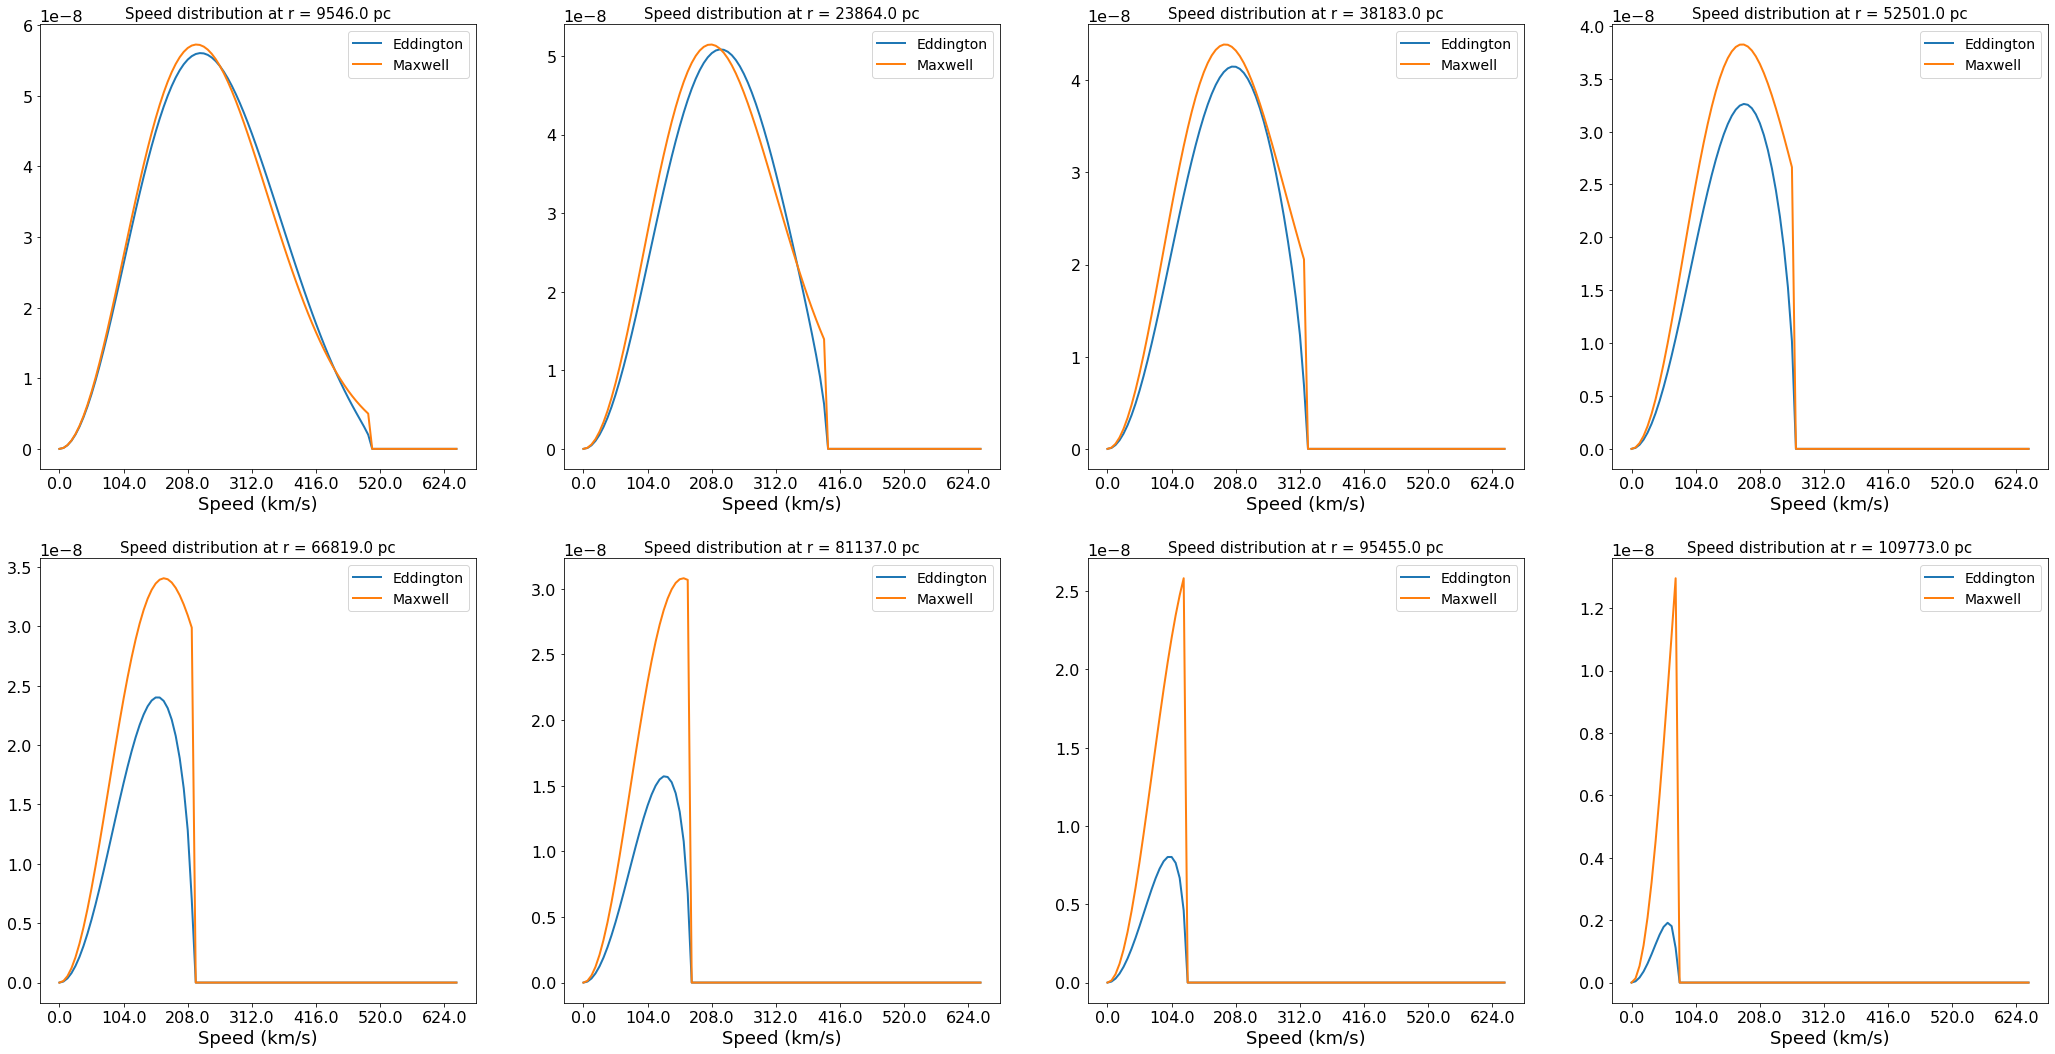

In [154]:
# Slicing at particular radii
fig, axs = plt.subplots(2,4,figsize=(36,18))

num_x_labels = 7
step_s = int(nSpeeds/(num_x_labels-1))

rIndices = np.array((8,20,32,44,56,68,80,92))
print(rIndices)

axs[0,0].plot(pdfEddingtonImage[int(rIndices[0]),:],label='Eddington')
axs[0,0].plot(pdfMBImage[int(rIndices[0]),:],label='Maxwell')
axs[0,0].set_xticks(np.arange(0,nSpeeds,step_s))
axs[0,0].set_xticklabels(np.round(speeds[::step_s]))
axs[0,0].set_xlabel('Speed (km/s)')
axs[0,0].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[0])])) + ' pc')
axs[0,0].legend()

axs[0,1].plot(pdfEddingtonImage[int(rIndices[1]),:],label='Eddington')
axs[0,1].plot(pdfMBImage[int(rIndices[1]),:],label='Maxwell')
axs[0,1].set_xticks(np.arange(0,nSpeeds,step_s))
axs[0,1].set_xticklabels(np.round(speeds[::step_s]))
axs[0,1].set_xlabel('Speed (km/s)')
axs[0,1].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[1])])) + ' pc')
axs[0,1].legend()

axs[0,2].plot(pdfEddingtonImage[int(rIndices[2]),:],label='Eddington')
axs[0,2].plot(pdfMBImage[int(rIndices[2]),:],label='Maxwell')
axs[0,2].set_xticks(np.arange(0,nSpeeds,step_s))
axs[0,2].set_xticklabels(np.round(speeds[::step_s]))
axs[0,2].set_xlabel('Speed (km/s)')
axs[0,2].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[2])])) + ' pc')
axs[0,2].legend()

axs[0,3].plot(pdfEddingtonImage[int(rIndices[3]),:],label='Eddington')
axs[0,3].plot(pdfMBImage[int(rIndices[3]),:],label='Maxwell')
axs[0,3].set_xticks(np.arange(0,nSpeeds,step_s))
axs[0,3].set_xticklabels(np.round(speeds[::step_s]))
axs[0,3].set_xlabel('Speed (km/s)')
axs[0,3].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[3])])) + ' pc')
axs[0,3].legend()

axs[1,0].plot(pdfEddingtonImage[int(rIndices[4]),:],label='Eddington')
axs[1,0].plot(pdfMBImage[int(rIndices[4]),:],label='Maxwell')
axs[1,0].set_xticks(np.arange(0,nSpeeds,step_s))
axs[1,0].set_xticklabels(np.round(speeds[::step_s]))
axs[1,0].set_xlabel('Speed (km/s)')
axs[1,0].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[4])])) + ' pc')
axs[1,0].legend()

axs[1,1].plot(pdfEddingtonImage[int(rIndices[5]),:],label='Eddington')
axs[1,1].plot(pdfMBImage[int(rIndices[5]),:],label='Maxwell')
axs[1,1].set_xticks(np.arange(0,nSpeeds,step_s))
axs[1,1].set_xticklabels(np.round(speeds[::step_s]))
axs[1,1].set_xlabel('Speed (km/s)')
axs[1,1].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[5])])) + ' pc')
axs[1,1].legend()

axs[1,2].plot(pdfEddingtonImage[int(rIndices[6]),:],label='Eddington')
axs[1,2].plot(pdfMBImage[int(rIndices[6]),:],label='Maxwell')
axs[1,2].set_xticks(np.arange(0,nSpeeds,step_s))
axs[1,2].set_xticklabels(np.round(speeds[::step_s]))
axs[1,2].set_xlabel('Speed (km/s)')
axs[1,2].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[6])])) + ' pc')
axs[1,2].legend()

axs[1,3].plot(pdfEddingtonImage[int(rIndices[7]),:],label='Eddington')
axs[1,3].plot(pdfMBImage[int(rIndices[7]),:],label='Maxwell')
axs[1,3].set_xticks(np.arange(0,nSpeeds,step_s))
axs[1,3].set_xticklabels(np.round(speeds[::step_s]))
axs[1,3].set_xlabel('Speed (km/s)')
axs[1,3].set_title('Speed distribution at r = ' + str(np.round(radii[int(rIndices[7])])) + ' pc')
axs[1,3].legend()

In [ ]:
radialPDF_Eddington = np.zeros(nRadii)
radialPDF_MB = np.zeros(nRadii)
radialPDF_MB_nocutoff = np.zeros(nRadii)
nuTimesArea = np.zeros(nRadii)
nuFromMass = np.zeros(nRadii)

for i in range(nRadii):
    #radialPDF_Eddington[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.PSD_Eddington(radii[i],x),0,mwHalo.maxSpeed(radii[i]))[0]
    radialPDF_EddingtonTry2[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.PSD_Eddington_2(radii[i],x),0,mwHalo.maxSpeed(radii[i]))[0]
    nuTimesArea[i] = (4*np.pi*radii[i]**2)*mwHalo.nu_r(radii[i])
    nuFromMass[i] = (4*np.pi*radii[i]**2)*mwHalo.nu_r_by_mass(radii[i])
    #radialPDF_MB[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.phaseSpaceDensityMB(radii[i],x),0,mwHalo.maxSpeed(radii[i]))[0]
    #radialPDF_MB_nocutoff[i] = integrate.quad(lambda x: (4*np.pi*radii[i]*x)**2*mwHalo.phaseSpaceDensityMB_noCutoff(radii[i],x),0,np.inf)[0]

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.plot(radii,radialPDF_EddingtonTry2)
ax2.plot(radii,nuFromMass)
#plt.plot(radii,radialPDF_MB_nocutoff)

plt.figure()
plt.plot(radii,radialPDF_EddingtonTry2)
plt.plot(radii,nuFromMass)